# Processing and cleaning the Ames housing dataset

 The original dataset is available [here](http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls). A version of the dataset is available [on Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). This is the dataset we'll be working with.
 
In this notebook, we'll do preliminary processing and cleaning of the original dataset. In later notebooks we'll [explore the cleaned data and select/engineer features](eda.ipynb/#Exploratory-analysis-of-Ames-housing-dataset) and [model and predict sale prices](model.ipynb/#Modeling-and-predicting-SalePrice). Local copies of all datasets are in `house_prices/data`.

In [2]:
import os
os.getcwd()

'/Users/home/Library/Mobile Documents/com~apple~CloudDocs/.Trash/notebooks 3.47.51 PM'

## Setup

In [41]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style('whitegrid')
import warnings

import os
import sys

warnings.filterwarnings('ignore')
# add parent directory for importing custom classes
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pardir)

# custom class for data description
from codes.process import *
from numpy import nan

## Load and inspect Data

### Variable descriptions

A description of the dataset variables is available in `data/data_description.txt`, but it requires a little bit of preprocessing. The custom augmented `dict` class `DataDescription` contains code to do this (see `house_prices/codes/preprocess.py`)

In [3]:
desc = DataDescription('../data/data_description.txt')

In [4]:
# First five variable names
list(desc.keys())[:5]

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street']

In [5]:
# First variable description and values
desc['MSSubClass']

{'Description': ' Identifies the type of dwelling involved in the sale.',
 'Values': {'20': '1-STORY 1946 & NEWER ALL STYLES',
  '30': '1-STORY 1945 & OLDER',
  '40': '1-STORY W/FINISHED ATTIC ALL AGES',
  '45': '1-1/2 STORY - UNFINISHED ALL AGES',
  '50': '1-1/2 STORY FINISHED ALL AGES',
  '60': '2-STORY 1946 & NEWER',
  '70': '2-STORY 1945 & OLDER',
  '75': '2-1/2 STORY ALL AGES',
  '80': 'SPLIT OR MULTI-LEVEL',
  '85': 'SPLIT FOYER',
  '90': 'DUPLEX - ALL STYLES AND AGES',
  '120': '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
  '150': '1-1/2 STORY PUD - ALL AGES',
  '160': '2-STORY PUD - 1946 & NEWER',
  '180': 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
  '190': '2 FAMILY CONVERSION - ALL STYLES AND AGES'}}

### Load into `DataFrame`

We'll combine training and test data into a single `DataFrame`

In [6]:
train = pd.read_csv('../data/train.csv', index_col='Id')
test = pd.read_csv('../data/test.csv', index_col='Id')
full = pd.concat([train, test], keys=['train', 'test'], axis=0, sort=False)

In [7]:
full.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
      Id                                                                    
train 1           60       RL         65.0     8450   Pave   NaN      Reg   
      2           20       RL         80.0     9600   Pave   NaN      Reg   
      3           60       RL         68.0    11250   Pave   NaN      IR1   
      4           70       RL         60.0     9550   Pave   NaN      IR1   
      5           60       RL         84.0    14260   Pave   NaN      IR1   

         LandContour Utilities LotConfig  ... PoolArea PoolQC Fence  \
      Id                                  ...                         
train 1          Lvl    AllPub    Inside  ...        0    NaN   NaN   
      2          Lvl    AllPub       FR2  ...        0    NaN   NaN   
      3          Lvl    AllPub    Inside  ...        0    NaN   NaN   
      4          Lvl    AllPub    Corner  ...        0    NaN   NaN   
      5          Lvl    AllPub       FR2  ...        0    NaN   NaN   

         MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  \
      Id                                                               
train 1          NaN       0      2    2008        WD         Normal   
      2          NaN       0      5    2007        WD         Normal   
      3          NaN       0      9    2008        WD         Normal   
      4          NaN       0      2    2006        WD        Abnorml   
      5          NaN       0     12    2008        WD         Normal   

          SalePrice  
      Id             
train 1    208500.0  
      2    181500.0  
      3    223500.0  
      4    140000.0  
      5    250000.0  

[5 rows x 80 columns]

In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, (train, 1) to (test, 2919)
Data columns (total 80 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior

We can see some cleanup and preprocessing will be necessary. For example, there are quite a few missing values, and more than half the variables have been have been cast to `pandas` catch-all `object` dtype.

About half of the data is training data and half is testing data - observations from the testing data have `NaN` values for `SalePrice`

In [9]:
# shape of training data
full.loc['train'].shape

(1460, 80)

In [10]:
# shape of training data
full.loc['test'].shape

(1459, 80)

## Clean data

Note: all the functions in [this section](#Drop-problematic-variables-and-observations) are rolled into `HPDataFramePlus` methods `encode_ords, drop_probs`

Before we clean any data, we'll store the original dataset so we have an unadulaterated copy

In [11]:
# create instance of HPDataFramePlus for full dataset
orig = HPDataFramePlus(data=full)

### Classify variables by kind

Since it doesn't affect the data, we'll group variables in the original dataset into categorical, ordinal and quantitative kinds. We'll use the custom class `HPDataFramePlus` which contains helpful methods

In [12]:
# set description attribute
orig.desc = desc

# view description of all variables except sale price
cols = list(full.columns)
cols.remove('SalePrice')
orig.print_desc(cols)

MSSubClass: Identifies the type of dwelling involved in the sale.

	 20 - 1-STORY 1946 & NEWER ALL STYLES
	 30 - 1-STORY 1945 & OLDER
	 40 - 1-STORY W/FINISHED ATTIC ALL AGES
	 45 - 1-1/2 STORY - UNFINISHED ALL AGES
	 50 - 1-1/2 STORY FINISHED ALL AGES
	 60 - 2-STORY 1946 & NEWER
	 70 - 2-STORY 1945 & OLDER
	 75 - 2-1/2 STORY ALL AGES
	 80 - SPLIT OR MULTI-LEVEL
	 85 - SPLIT FOYER
	 90 - DUPLEX - ALL STYLES AND AGES
	 120 - 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
	 150 - 1-1/2 STORY PUD - ALL AGES
	 160 - 2-STORY PUD - 1946 & NEWER
	 180 - PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
	 190 - 2 FAMILY CONVERSION - ALL STYLES AND AGES


MSZoning: Identifies the general zoning classification of the sale.

	 A - Agriculture
	 C - Commercial
	 FV - Floating Village Residential
	 I - Industrial
	 RH - Residential High Density
	 RL - Residential Low Density
	 RP - Residential Low Density Park 
	 RM - Residential Medium Density


LotFrontage: Linear feet of street connected to propert

To classify the variables, there's really no alternative here than to carefully inspect the variable descriptions and determine which is which. To clarify our terms:

- Categorical variables are discrete variables with no ordering (although they may have a numerical encoding)
- Ordinal variables are discrete numeric variables, hence they have an ordering (and should be numerically encoded)
- Quantiative variables are continuous numeric variables

In [13]:
# split variables into categorical, ordinal, quantitative
cat_cols = ['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
            'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 
            'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 'Alley']
ord_cols = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 
            'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
            'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
            'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
            'MoSold', 'YrSold']
quant_cols = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
              'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
              'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
              'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
              'SalePrice']

# group columns by kind
col_kinds = {'cat': cat_cols, 'ord': ord_cols, 'quant': quant_cols}

# set col_kinds attribute
orig.col_kinds = col_kinds

Now the cleaning begins.

In [14]:
# create new dataframe for cleaned data and set attributes
clean = HPDataFramePlus(data=full)
clean.col_kinds = orig.col_kinds
clean.desc = orig.desc

### Encode variables

Before we can clean, we need to make sure all variables are encoded appropriately. Let's compare the dtypes of our dataframe with the variable types

In [15]:
# dtypes for categorical variables
clean.data[clean.col_kinds['cat']].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, (train, 1) to (test, 2919)
Data columns (total 24 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
Street           2919 non-null object
LandContour      2919 non-null object
LotConfig        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non-null object
MasVnrType       2895 non-null object
Foundation       2919 non-null object
Heating          2919 non-null object
CentralAir       2919 non-null object
Electrical       2918 non-null object
GarageType       2762 non-null object
MiscFeature      105 non-null object
SaleType         2918 non-null object
SaleCondition    2919 non-null object
Alle

In [16]:
# dtypes for ordinal variables
clean.data[clean.col_kinds['ord']].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, (train, 1) to (test, 2919)
Data columns (total 33 columns):
LotShape        2919 non-null object
Utilities       2917 non-null object
LandSlope       2919 non-null object
OverallQual     2919 non-null int64
OverallCond     2919 non-null int64
ExterQual       2919 non-null object
ExterCond       2919 non-null object
BsmtQual        2838 non-null object
BsmtCond        2837 non-null object
BsmtExposure    2837 non-null object
BsmtFinType1    2840 non-null object
BsmtFinType2    2839 non-null object
HeatingQC       2919 non-null object
BsmtFullBath    2917 non-null float64
BsmtHalfBath    2917 non-null float64
FullBath        2919 non-null int64
HalfBath        2919 non-null int64
BedroomAbvGr    2919 non-null int64
KitchenAbvGr    2919 non-null int64
KitchenQual     2918 non-null object
TotRmsAbvGrd    2919 non-null int64
Functional      2917 non-null object
Fireplaces      2919 non-null int64
FireplaceQu     1499 non-null o

In [17]:
# dtypes for quantitative variables
clean.data[clean.col_kinds['quant']].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, (train, 1) to (test, 2919)
Data columns (total 23 columns):
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
MasVnrArea       2896 non-null float64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtUnfSF        2918 non-null float64
TotalBsmtSF      2918 non-null float64
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
LowQualFinSF     2919 non-null int64
GrLivArea        2919 non-null int64
GarageYrBlt      2760 non-null float64
GarageArea       2918 non-null float64
WoodDeckSF       2919 non-null int64
OpenPorchSF      2919 non-null int64
EnclosedPorch    2919 non-null int64
3SsnPorch        2919 non-null int64
ScreenPorch      2919 non-null int64
PoolArea         2919 non-null int64
MiscVal          2919 non-null int64
SalePrice        1460 non-null float64
dtypes:

Categorical and quantitative dtypes look good, but we'll need to deal with the ordinal variables.

In [18]:
# inspect description of ordinal variables
clean.print_desc(clean.col_kinds['ord'])

LotShape: General shape of property

	 Reg - Regular
	 IR1 - Slightly irregular
	 IR2 - Moderately Irregular
	 IR3 - Irregular


Utilities: Type of utilities available

	 AllPub - All public Utilities (E,G,W,& S)
	 NoSewr - Electricity, Gas, and Water (Septic Tank)
	 NoSeWa - Electricity and Gas Only
	 ELO - Electricity only


LandSlope: Slope of property

	 Gtl - Gentle slope
	 Mod - Moderate Slope
	 Sev - Severe Slope


OverallQual: Rates the overall material and finish of the house

	 10 - Very Excellent
	 9 - Excellent
	 8 - Very Good
	 7 - Good
	 6 - Above Average
	 5 - Average
	 4 - Below Average
	 3 - Fair
	 2 - Poor
	 1 - Very Poor


OverallCond: Rates the overall condition of the house

	 10 - Very Excellent
	 9 - Excellent
	 8 - Very Good
	 7 - Good
	 6 - Above Average
	 5 - Average
	 4 - Below Average
	 3 - Fair
	 2 - Poor
	 1 - Very Poor


ExterQual: Evaluates the quality of the material on the exterior 

	 Ex - Excellent
	 Gd - Good
	 TA - Average/Typical
	 Fa - Fair
	 Po 

Upon careful reflection, we'll encode the ordinal variable values by hand (taking care to distinguish between values of 0 and truly missing values)

In [21]:
# encode ordinal variable values in dictionary by hand when needed
ords = {}
ords['GarageCond'] = {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
ords['BsmtCond'] = ords['GarageCond'].copy()
ords['BsmtCond'].pop('Ex')
ords['LandSlope'] = {'Gtl': 0, 'Mod': 1, 'Sev': 2}
ords['PavedDrive'] = {'N': 0, 'P': 1, 'Y': 2}
ords['GarageFinish'] = {nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
ords['BsmtQual'] = {nan: 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
ords['GarageQual'] = ords['GarageCond'].copy()
ords['LotShape'] = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
ords['Functional'] = {name: i for (i, name) in
                      enumerate(reversed(
                        orig.data['Functional'].unique()[:-1]))}
ords['Functional'][nan] = nan
ords['ExterCond'] = ords['GarageCond'].copy()
ords['ExterQual'] = {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
ords['HeatingQC'] = ords['GarageCond'].copy()
ords['KitchenQual'] = ords['BsmtQual'].copy()
ords['BsmtFinType1'] = {nan: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4,
                        'ALQ': 5, 'GLQ': 6}
ords['BsmtFinType2'] = ords['BsmtFinType1'].copy()
ords['BsmtExposure'] = {nan: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
ords['Fence'] = {nan: 0, 'MnPrv': 1, 'MnWw': 2, 'GdWo': 3, 'GdPrv': 4}
ords['FireplaceQu'] = ords['GarageCond'].copy()
ords['PoolQC'] = ords['BsmtQual'].copy()
ords['Utilities'] = {nan: nan, 'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3}

# perform encoding
clean.data = clean.encode_ords(mapper=ords)

### Drop problematic variables and observations

Now that all variables are properly encoded, we can drop those with too many missing values immediately. We'll be somewhat conservative and drop variables missing $>20\%$ of values

In [22]:
def drop_mostly_missing_cols(hpdf):
    """Drop columns with too many missing values"""
    copy = hpdf.data.copy()
    # drop columns with more than 20% values missing
    notna_col_mask = ~ (copy.isna().sum()/len(copy) > 0.20)
    notna_col_mask.loc['SalePrice'] = True
    copy = copy.loc[: , notna_col_mask]
    # drop columns associated with those
    copy.drop(columns=['MiscVal'])
    return copy

# create a new dataframe for cleaning
clean.data = drop_mostly_missing_cols(clean)
clean.update_col_kinds(clean.col_kinds)

We'll also drop some well-known outlying observations (at least, well-known on Kaggle ) in the training data. Dropping outliers is (for good reason) very controversial, and one should take great care in doing so. The justification for it depends on context, however. In our case, the end goal is to predict `SalePrice` accuractely. If dropping outliers improves the ability of our prediction model to generalize, than this may provide some retroactive justification.

First we'll plot the outliers (identifying them by their relationship to `SalePrice`)

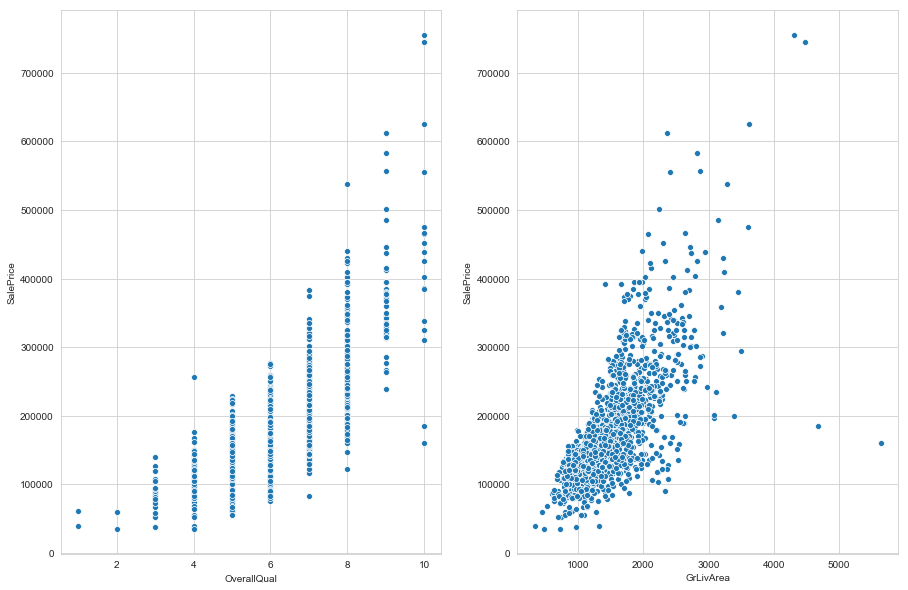

In [23]:
def plot_outliers(hpdf):
    """Plot variables which contain well-known outliers."""
    plt.subplots(1, 2, figsize=(15, 10))
    train = hpdf.data.loc['train', :]
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='OverallQual', y='SalePrice', data=train)
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)


plot_outliers(clean)

Kagglers seem to frequently conclude that the outliers are the house with overall quality 4 but a sale price of more than \\$250,000, and the two houses with more than 4500 sq ft of general living area but sale prices less than \\$300,000.

Whether this is well-justified, and how much it's an example of groupthink, is a matter for debate. But it seems to regularly improve the predictive capability of models, so we'll follow suit.

In [24]:
def drop_outliers(hpdf):
    copy = hpdf.data.copy()
    # drop outliers in OverallQual
    idx = copy[(copy['OverallQual'] < 5) & (copy['SalePrice'] > 200000)].index[0][1]
    copy = copy.drop(labels=[idx], axis=0, level='Id')
    # drop outliers in GrLivArea
    idx = copy[(copy['GrLivArea'] > 4000) & (copy['SalePrice'] < 300000)].index[0][1]
    copy = copy.drop(labels=[idx], axis=0, level='Id')
    
    return copy

clean.data = drop_outliers(clean)
clean.update_col_kinds(clean.col_kinds)

Finally, we'll see if there are any categorical variables with extremely unbalanced distributions

In [25]:
def print_unbal_dists(data, bal_threshold):
    """Print distributions of columns with more than bal_threshold proportion concentrated at a single value."""
    dists = []
    for col in data.columns:
        val_counts = data[col].value_counts()
        dist = val_counts/sum(val_counts)
        if dist.max() > bal_threshold:
            dists += [dist]
    for dist in dists:
        print()
        print(dist)

### Missing Values

Our dataset is missing a lot of values!

In [26]:
# counts of missing values by variable, excluding SalePrice
clean.na_counts().drop('SalePrice')

MSZoning          4
LotFrontage     485
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
Functional        2
GarageType      157
GarageYrBlt     159
GarageCars        1
GarageArea        1
SaleType          1
dtype: int64

#### Inspect train and test distributions of missing values

 Before we get into imputing them, to inform our choice of methods, let's see how their distributions might differ across training and test sets. We want to be careful imputing missing values when those missing values are distributed unevenly across train and test sets if our goal is prediction, since our imputation could introduce further difference between train and test sets.

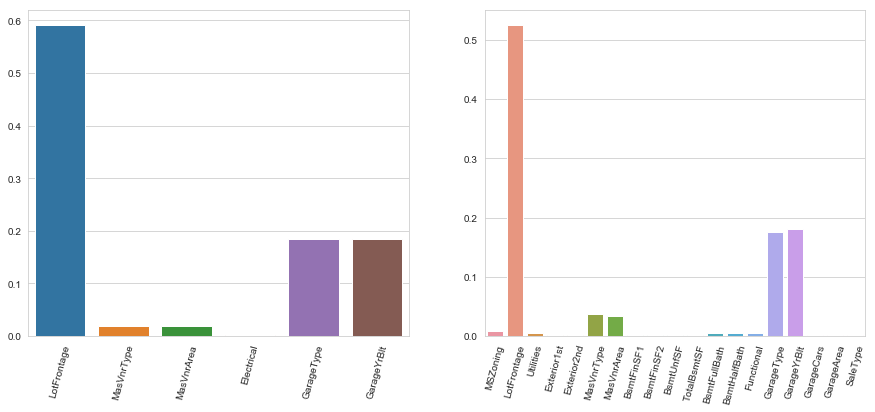

In [27]:
def plot_train_and_test_missing_values(hpdf):
    """plot distribution of missing train values."""
    
    copy = hpdf.data.drop(columns=['SalePrice'])
    train = HPDataFramePlus(data=copy.loc['train', :])
    test = HPDataFramePlus(data=copy.loc['test', :])
    
    fig, _ = plt.subplots(1, 2, figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    train_missing_dist = train.na_counts()/train.na_counts().sum()
    sns.barplot(x=train_missing_dist.index, y=train_missing_dist.values)
    plt.xticks(rotation=75)
    
    plt.subplot(1, 2, 2)
    test_missing_dist = test.na_counts()/test.na_counts().sum()
    sns.barplot(x=test_missing_dist.index, y=test_missing_dist.values)
    plt.xticks(rotation=75)

plot_train_and_test_missing_values(clean)

In [28]:
# variables missing values in train but not test set
train_missing = HPDataFramePlus(data=clean.data.loc['train', :]).na_counts()
test_missing = HPDataFramePlus(data=clean.data.loc['test', :]).na_counts()
train_not_test = list(set(train_missing.index).difference(test_missing.index))
train_not_test

['Electrical']

In [29]:
# variables missing values in test but not train set
test_not_train = list(set(test_missing.index).difference(train_missing.index))
test_not_train

['GarageArea',
 'Exterior2nd',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1',
 'Functional',
 'Utilities',
 'GarageCars',
 'TotalBsmtSF',
 'SaleType',
 'BsmtFullBath',
 'MSZoning',
 'Exterior1st',
 'SalePrice']

In [30]:
# count of variables missing values in train but not test set
train_missing.loc[train_not_test]

Electrical    1
dtype: int64

In [31]:
# count of variables missing values in test but not train
test_missing.loc[test_not_train].drop(index=['SalePrice'])

GarageArea      1
Exterior2nd     1
BsmtHalfBath    2
BsmtUnfSF       1
BsmtFinSF2      1
BsmtFinSF1      1
Functional      2
Utilities       2
GarageCars      1
TotalBsmtSF     1
SaleType        1
BsmtFullBath    2
MSZoning        4
Exterior1st     1
dtype: int64

Since there are so few missing values for variables which are missing values in the train set not the test set (or vice versa), we won't worry about imputing them. 

Now let's look at the distributions of variables missing in both train and test sets

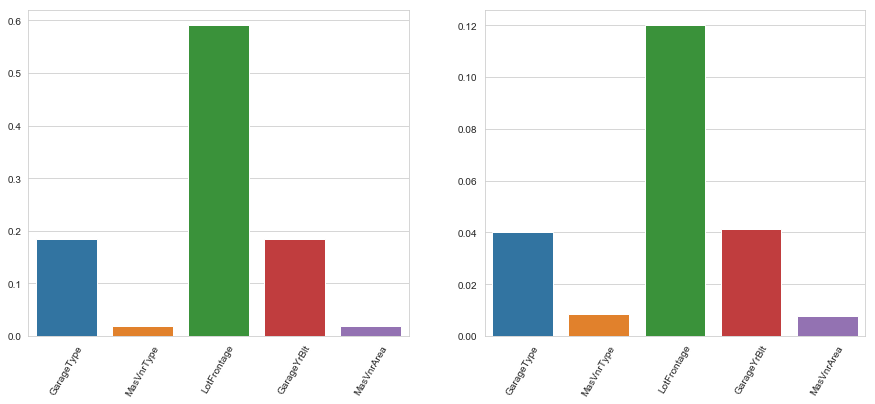

In [32]:
def plot_both_train_and_test_missing_values(hpdf):
    """plot distribution of missing train values."""
    
    copy = hpdf.data.drop(columns=['SalePrice'])
    train_missing_dist = HPDataFramePlus(data=clean.data.loc['train', :]).na_counts()
    train_missing_dist = train_missing_dist/sum(train_missing_dist)
    
    test_missing_dist = HPDataFramePlus(data=clean.data.loc['test', :]).na_counts()
    test_missing_dist = test_missing_dist/sum(test_missing_dist)
    
    both_missing_index = set(train_missing_dist.index).intersection(test_missing_dist.index)
    train_missing_dist = train_missing_dist.loc[both_missing_index]
    test_missing_dist = test_missing_dist.loc[both_missing_index]
    
    fig, _ = plt.subplots(1, 2, figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x=train_missing_dist.index, y=train_missing_dist.values)
    plt.xticks(rotation=60)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=test_missing_dist.index, y=test_missing_dist.values)
    plt.xticks(rotation=60)

plot_both_train_and_test_missing_values(clean)

For variables missing values in both sets, the distributions are very similar, so we'll go ahead and impute these values

#### Impute small numbers of missing values by hand

Imputation of missing values using point estimates (mean, mode, etc.) is very common but arguable somewhat crude. Since there are more sophisticated methods which aren't too difficult to use, we'd like to use them. They are however, a bit more computationally expensive. Since many of our variables are only missing a few values, imputing these values by hand using point estimates will cut down on computational cost while sacrificing little.

An excellent, thorough treatment of imputation can be found in [Flexible Imputation of Missing Data](https://stefvanbuuren.name/fimd/) by Stef Van Buren.

In [33]:
# Impute variables with <= 4 missing values. Use mode for categoricals, median for quantitatives
clean.data = clean.hand_impute()

In [34]:
# missing value counts again
clean.na_counts().drop(index=['SalePrice'])

LotFrontage    485
MasVnrType      24
MasVnrArea      23
GarageType     157
GarageYrBlt    159
dtype: int64

#### Impute missing categorical values with `XGBClassifier`

Some methods for imputing missing categorical data are more common, e.g. multinomial classification, but any classifier will do. Given time and the inclination, one could explore different classifiers and try to estimate their imputation accuracy (e.g. by cross-validation on data with no missing values) but we won't do that here. Since `xgboost` classifier often performs very well with defaults, we'll use it to impute `MasVnrType` and `GarageType`.

In [35]:
# impute missing categorical values with XGBClassifier
clean.data = clean.impute_cats(response='SalePrice')

In [36]:
# missing value counts again
clean.na_counts().drop(index=['SalePrice'])

LotFrontage    485
MasVnrArea      23
GarageYrBlt    159
dtype: int64

#### Impute missing quantitative values with MICE and PMM

[Multiple Imputation with Chained Equations (MICE)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/) is principled method of imputing missing data. It can be combined with [Predictive Mean Matching (PMM)](http://stefvanbuuren.name/fimd/sec-pmm.html) to yield a powerful implementation method. One can find these methods implemented in Python in `statsmodels.imputation.mice`.

In [37]:
# impute missing quantitative values with MICE and PMM
clean.data = clean.impute_quants(response='SalePrice')

In [38]:
# missing value counts again
clean.na_counts().drop(index=['SalePrice'])

Series([], dtype: int64)

### Enforce dtypes

On top of our `col_kinds` dictionary, we'll use pandas dtypes to track categorical, ordinal, and quantitative variables

In [39]:
cats, ords, quants = (clean.col_kinds['cat'], clean.col_kinds['ord'],
                          clean.col_kinds['quant'])
clean.data.loc[:, cats] = clean.data.loc[:, cats].astype('category')
clean.data.loc[:, ords] = clean.data.loc[:, ords].astype('int64')
clean.data.loc[:, 'MSSubClass'] = clean.data['MSSubClass'].astype(
                                      'category')
clean.data.loc[:, quants] = clean.data.loc[:, quants].astype('float64')
clean.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2917 entries, (train, 1) to (test, 2919)
Data columns (total 78 columns):
MSSubClass       2917 non-null category
MSZoning         2917 non-null category
LotFrontage      2917 non-null float64
LotArea          2917 non-null float64
Street           2917 non-null category
LotShape         2917 non-null int64
LandContour      2917 non-null category
Utilities        2917 non-null int64
LotConfig        2917 non-null category
LandSlope        2917 non-null int64
Neighborhood     2917 non-null category
Condition1       2917 non-null category
Condition2       2917 non-null category
BldgType         2917 non-null category
HouseStyle       2917 non-null category
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null float64
YearRemodAdd     2917 non-null float64
RoofStyle        2917 non-null category
RoofMatl         2917 non-null category
Exterior1st      2917 non-null category
Exterior2nd    

## Save processed data

Finally we'll save our datasets to disk. This will result in two files

- `orig.csv` - Original train and test data combined in a single dataset, without any modification
- `clean.csv` - Cleaned dataset, with problematic variables and observations dropped and missing values imputed

In [42]:
hp_data = DataPlus({'orig': orig, 'clean': clean})
data_dir = '../data'
hp_data.save_dfs(save_dir=data_dir)